In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import numpy as np
import matplotlib.pyplot as plt

from shap_enhanced.explainers.sequential_attention.recurrent_explainer import RecurrentExplainer
from shap_enhanced.explainers.sequential_attention.sp_shap_explainer import SPShapExplainer
from shap_enhanced.explainers.sequential_attention.time_explainer import TimeExplainer
from shap_enhanced.explainers.sequential_attention.ts_shap_explainer import TSShapExplainer


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RealisticLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def generate_robust_data(seq_len=30, top_k=5, noise_std=0.05):
    time = np.arange(seq_len)
    signal = np.sin(0.1 * time) + 0.5 * np.cos(0.05 * time) + 0.2 * np.sin(0.03 * time)
    signal += np.random.normal(0, noise_std, size=seq_len)
    X = torch.tensor(signal, dtype=torch.float32).view(1, seq_len, 1)

    importance = torch.abs(X.squeeze())
    importance /= importance.max()
    y = X.squeeze()[importance.argsort(descending=True)[:top_k]].sum().unsqueeze(0).unsqueeze(0)
    return X, y, importance

def generate_strange_data(seq_len=30, noise_std=0.05) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    time = np.linspace(0, 1, seq_len)

    base = 0.5 * np.sin(10 * np.pi * time) + 0.3 * np.exp(-6 * (time - 0.5)**2)
    mod = 0.2 * (1 / (1 + np.exp(-20 * (time - 0.3)))) + 0.1 * np.cos(40 * time)
    signal = base * mod + np.random.normal(0, noise_std, size=seq_len)

    X = torch.tensor(signal, dtype=torch.float32).view(1, seq_len, 1)

    importance = (
        0.5 * torch.tensor(base, dtype=torch.float32) +
        0.5 * torch.tensor(mod, dtype=torch.float32)
    ).abs()

    importance /= importance.max() + 1e-6  # normalize

    y = (X.squeeze() * importance).sum().unsqueeze(0).unsqueeze(0)

    return X, y, importance

In [3]:
# Train the realistic model
model = RealisticLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

X, y, true_importance = generate_strange_data()
for epoch in range(300):  # Increased epochs and realistic settings
    model.train()
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()



In [4]:
background = torch.randn(100, X.shape[1], X.shape[2])

# Recurrent SHAP Explanation
explainer_recurrent = RecurrentExplainer(model=model)
shap_recurrent = explainer_recurrent.explain(X)

# SP SHAP Explanation
explainer_sp = SPShapExplainer(model=model)
shap_sp = explainer_sp.explain(X)

# Time SHAP Explanation
explainer_time = TimeExplainer(model=model)
shap_time = explainer_time.explain(X)

# TS SHAP Explanation
explainer_ts = TSShapExplainer(model=model, background=background)
shap_ts = explainer_ts.explain(X)

# SHAP DeepExplainer
explainer_shap = shap.DeepExplainer(model, background)
shap_deep = explainer_shap.shap_values(X)

# Compute estimated importance
estimated_importance_recurrent = shap_recurrent.detach().cpu().numpy().flatten()
estimated_importance_sp = shap_sp.detach().cpu().numpy().flatten()
estimated_importance_time = shap_time.detach().cpu().numpy().flatten()
estimated_importance_ts = shap_ts.detach().cpu().numpy().flatten()
estimated_importance_deep = np.abs(shap_deep[0]).flatten()

# Normalize all importance scores
true_norm = true_importance.numpy()
est_norm_recurrent = estimated_importance_recurrent / (np.abs(estimated_importance_recurrent).max() + 1e-6)
est_norm_sp = estimated_importance_sp / (np.abs(estimated_importance_sp).max() + 1e-6)
est_norm_time = estimated_importance_time / (np.abs(estimated_importance_time).max() + 1e-6)
est_norm_ts = estimated_importance_ts / (np.abs(estimated_importance_ts).max() + 1e-6)
est_norm_deep = estimated_importance_deep / (estimated_importance_deep.max() + 1e-6)



/home/niyang/repos/enhanced_shap/src/shap_enhanced/explainers/sequential_attention/recurrent_explainer.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(smoothed, device=attr.device, dtype=attr.dtype)


[Warning] Gradient boost skipped: element 0 of tensors does not require grad and does not have a grad_fn


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


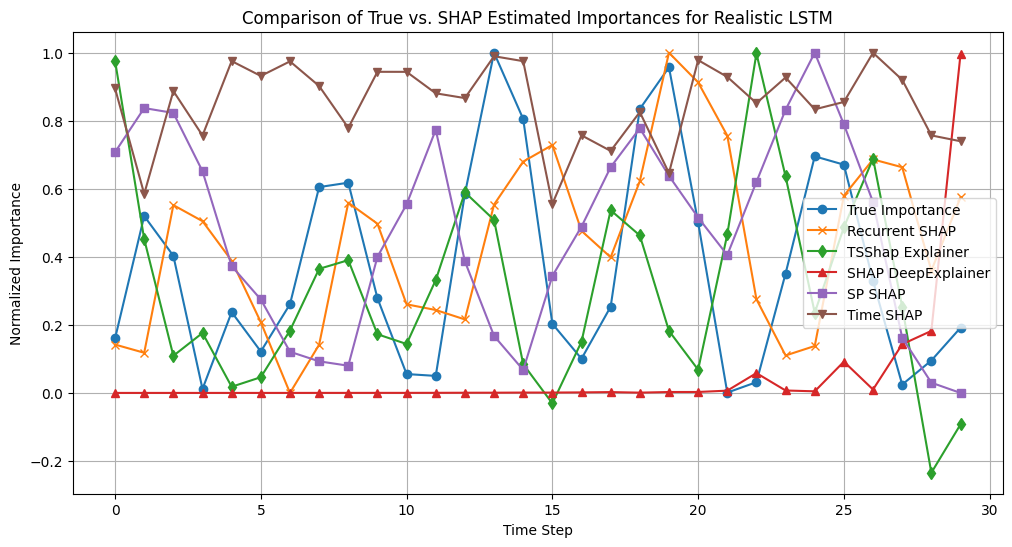

In [6]:
# Plot results with all estimates
plt.figure(figsize=(12, 6))
plt.plot(true_norm, label='True Importance', marker='o')
plt.plot(est_norm_recurrent, label='Recurrent SHAP', marker='x')
plt.plot(est_norm_ts, label='TSShap Explainer', marker='d')
plt.plot(est_norm_deep, label='SHAP DeepExplainer', marker='^')
plt.plot(est_norm_sp, label='SP SHAP', marker='s')
plt.plot(est_norm_time, label='Time SHAP', marker='v')
plt.title('Comparison of True vs. SHAP Estimated Importances for Realistic LSTM')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.legend()
plt.grid(True)
plt.show()